In [1]:
import jax
from evox import Problem, algorithms,jit_class, monitors, workflows
from evox.operators import mutation, crossover, selection
from jax import random
import jax.numpy as jnp

import sys
sys.path.append('../my_es_algorithm')  # 添加路径到系统路径

In [2]:
Pd=10500
    
a=jnp.array([0.0069, 0.0069, 0.02028, 0.00942, 0.0114, 0.01142, 0.00357, 0.00492,
                        0.00573, 0.00605, 0.00515, 0.00569, 0.00421, 0.00752, 0.00708, 0.00708,
                        0.0031, 0.00313, 0.00313, 0.00313, 0.00298, 0.00298, 0.00284, 0.00284, 0.00277,
                        0.00277, 0.52124, 0.52124, 0.52124, 0.0114, 0.0016, 0.0016, 0.0016, 0.0001,
                        0.0001, 0.0001, 0.0161, 0.0161, 0.0161, 0.00313])
b=jnp.array([6.7300, 6.7300, 7.0700, 8.1800, 5.3500, 8.0500, 8.0300, 6.9900, 6.6000, 12.9000,
                        12.9000, 12.8000, 12.5000, 8.8400, 9.1500, 9.1500, 7.9700, 7.9500, 7.9700, 7.9700,
                         6.6300, 6.6300, 6.6600, 6.6600, 7.1000, 7.1000, 3.3300, 3.3300, 3.3300, 5.3500,
                         6.4300, 6.4300, 6.4300, 8.9500, 8.6200, 8.6200, 5.8800, 5.8800, 5.8800, 7.9700])
c=jnp.array([0.094705, 0.094705, 0.30954, 0.36903, 0.14889, 0.22233, 0.28771, 0.39198,
                        0.45576, 0.72282, 0.6352, 0.65469, 0.9134, 1.7604, 1.7283, 1.7283, 0.64785,
                        0.64969, 0.64783, 0.64781, 0.78596, 0.78596, 0.79453, 0.79453, 0.80132, 0.80132,
                        1.0551, 1.0551, 1.0551, 0.14889, 0.22292, 0.22292, 0.22292, 0.10787, 0.11658,
                        0.11658, 0.30745, 0.30745, 0.30745, 0.64783]) * 1000
g=jnp.array([
                100, 100, 100, 150, 120, 100, 200, 200, 200, 200, 200, 200, 300, 300, 300, 300,
                300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 120, 120, 120, 120, 150, 150,
                150, 200, 200, 200, 80, 80, 80, 300
            ])

h=jnp.array([
                0.0840, 0.0840, 0.0840, 0.0630, 0.0770, 0.0840, 0.0420, 0.0420, 0.0420, 0.0420,
                0.0420, 0.0420, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350,
                0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0350, 0.0770, 0.0770, 0.0770, 0.0770,
                0.0630, 0.0630, 0.0630, 0.0420, 0.0420, 0.0420, 0.0980, 0.0980, 0.0980, 0.0350
            ])
lb=jnp.array([36, 36, 60, 80, 47, 68, 110, 135, 135, 130, 94, 94, 125, 125, 125,
                           125, 220, 220, 242, 242, 254, 254, 254, 254, 254, 254, 10, 10, 10,
                           47, 60, 60, 60, 90, 90, 90, 25, 25, 25, 242])
ub=jnp.array([114, 114, 120, 190, 97, 140, 300, 300, 300, 300, 375, 375, 500, 500,
                           500, 500, 500, 500, 550, 550, 550, 550, 550, 550, 550, 550, 150, 150,
                           150, 97, 190, 190, 190, 200, 200, 200, 110, 110, 110, 550])

In [3]:
def initialize_center_with_constraints(key, Pd, lb, ub):
    n = lb.shape[0]  # 获取向量的长度
    # 1. 随机生成一个在 [lb, ub] 之间的初始向量
    random_init = jax.random.uniform(key, shape=(n,), minval=0.0, maxval=1.0)
    
    # 2. 通过线性插值将 random_init 映射到 [lb, ub] 之间
    scaled_init = lb + random_init * (ub - lb)
    
    # 3. 计算当前随机向量的和
    sum_scaled_init = jnp.sum(scaled_init)
    
    # 4. 将向量调整为和等于 Pd
    center_init = scaled_init * (Pd / sum_scaled_init)  # 重新缩放以使其和为 Pd
    
    # 5. 确保调整后的值仍然在 [lb, ub] 之间
    center_init = jnp.clip(center_init, lb, ub)
    
    return center_init

key = random.PRNGKey(2)
center_init = initialize_center_with_constraints(key, Pd, lb, ub)
print(center_init)

[ 50.452946  71.743164 120.       190.        97.        94.217514
 165.93658  300.       300.       197.93858  375.       120.08821
 365.22363  181.1079   201.60548  500.       500.       500.
 550.       550.       405.20096  517.7552   550.       346.80945
 519.1493   401.31702   87.787254 116.93457  150.        80.10183
 143.02684  138.74217  190.       118.06074  112.88136  185.89024
 110.        65.95288   50.843006 299.49225 ]


In [4]:
print(sum(center_init))

10020.26


In [5]:


def adjust_population_average(x, Pd, lb, ub):#单词平均调整
    n = x.shape[0]  # 获取发电机的数量  
    sumpop = jnp.sum(x)  # 计算所有发电机功率的总和
    df = sumpop - Pd  # 计算功率偏差

    # 计算每个发电机需要减少的平均功率
    df_per_generator = df / n
    
    # 从每个发电机的功率中减去平均偏差
    x_adjusted = x - df_per_generator
    
    # 确保更新后的值逐元素不超出上下限
    x_adjusted = jnp.clip(x_adjusted, lb, ub)
    
    return x_adjusted


def adjust_population_random(x, Pd, key, lb, ub):   #单次调整
    n = x.shape[0]  # 获取发电机的数量  
    sumpop = jnp.sum(x)  # 计算所有发电机功率的总和
    df = sumpop - Pd  # 计算功率偏差

    r = random.randint(key, shape=(), minval=0, maxval=n+1) #生成随机数
    # 从第r个发电机中减去总偏差
    x = x.at[r].set(x[r] - df)  # 使用 .at[].set() 更新特定索引的值

    # 确保更新后的值逐元素不超出上下限
    # x = jnp.clip(x, lb, ub)
    return x


def adjust_population_random_loop(x, Pd, key, tolerance):  # 多次调整
    n = x.shape[0]  # 获取发电机的数量

    def cond_fun(state):
        # x, sumpop, df, r = state
        x, sumpop = state
        return jnp.abs(sumpop - Pd) >= tolerance

    def body_fun(state):
        x, sumpop = state
        df = sumpop - Pd  # 计算功率偏差
        r = random.randint(key, shape=(), minval=0, maxval=n)  # 生成随机数
        x = x.at[r].set(x[r] - df)  # 使用 .at[].set() 更新特定索引的值
        # x = jnp.clip(x, lb, ub)  # 确保更新后的值不超出上下限
        sumpop = jnp.sum(x)  # 计算更新后所有发电机功率的总和
        return x, sumpop

    state = (x, jnp.sum(x))
    x, _= jax.lax.while_loop(cond_fun, body_fun, state)

    # 新增：将最终结果保留两位小数
    x = jnp.round(x, 2)
    
    return x

def _eld_openes(x):

    # x = adjust_population_average(x, Pd, lb, ub)
    key = random.PRNGKey(42)
    #x = adjust_population_random(x, Pd, key, lb, ub) #随机选择发电机调整
    #x = adjust_population_average(x, Pd, lb, ub) #机组平均调整
    #x = adjust_population_random_loop(x, Pd, key, lb, ub, tolerance=1e-1)#多次随机选择发电机调整
    # x = jnp.clip(x, lb, ub)  # 确保更新后的值不超出上下限
            
    return ((a * (x ** 2) + b * x + c).sum() + jnp.abs(g * jnp.sin(h * (Pd - x))).sum())



def eld_openes(x):
    return jax.vmap(_eld_openes, in_axes= 0)(x)



# @evox.jit_class
class ELD_OpenES(Problem):
    def __init__(self):
        super().__init__()
 
    def evaluate(self, State, x):
        return eld_openes(x), State

In [6]:
print((lb+ub)/2)

[ 75.   75.   90.  135.   72.  104.  205.  217.5 217.5 215.  234.5 234.5
 312.5 312.5 312.5 312.5 360.  360.  396.  396.  402.  402.  402.  402.
 402.  402.   80.   80.   80.   72.  125.  125.  125.  145.  145.  145.
  67.5  67.5  67.5 396. ]


In [7]:
clpso_solution_final= jnp.array([114.      , 114.      , 102.88154 , 177.61934 ,  96.48356 ,
       140.      , 300.      , 299.9996  , 300.      , 177.60959 ,
       102.82463 , 102.831665, 177.61775 , 357.15604 , 357.17252 ,
       267.39246 , 446.9602  , 446.9259  , 536.6901  , 536.6806  ,
       536.65076 , 536.6773  , 536.6747  , 536.69183 , 536.6736  ,
       536.6779  ,  14.411358,  14.415762,  14.42254 ,  96.55464 ,
       190.      , 189.99121 , 190.      , 178.03438 , 192.73204 ,
       177.87962 , 110.      , 110.      , 110.      , 536.6628  ])

In [8]:
from my_open_es import my_OpenES

algorithm = my_OpenES(
    #center_init = (lb+ub)/2,
    center_init = clpso_solution_final,  #clpso优化后得到的全局最优解作为初始化
    pop_size=10000,
    learning_rate=0.1,
    noise_stdev=0.5,
    lb=lb,              # 设置下界为一维数组
    ub=ub,              # 设置上界为一维数组
    optimizer=None,
    mirrored_sampling=False,
    )


In [9]:
#创建一个problem实例
Problem = ELD_OpenES()

monitor = monitors.EvalMonitor()
# create a workflow
workflow = workflows.StdWorkflow(
    algorithm,
    Problem,
    monitors=[monitor],
)

In [10]:
import time

# init the workflow
key = jax.random.PRNGKey(2)
state = workflow.init(key)

start_time = time.time()
# run the workflow for 100 steps
for i in range(500):
    state = workflow.step(state)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 2.0710997581481934 seconds


In [11]:
monitor.get_best_fitness()

Array(121027.47, dtype=float32)

In [12]:
monitor.get_best_solution()

Array([114.      , 113.770195, 102.9025  , 177.66599 ,  96.67516 ,
       139.7517  , 299.80063 , 299.5466  , 300.      , 177.62146 ,
       102.81155 , 102.9017  , 177.638   , 356.95197 , 357.5192  ,
       267.59293 , 446.4538  , 446.95682 , 536.5862  , 536.2579  ,
       536.6521  , 537.56396 , 536.8904  , 537.0216  , 536.9799  ,
       537.0524  ,  14.735229,  14.404591,  14.367811,  96.73224 ,
       189.83466 , 189.80156 , 189.9653  , 177.89746 , 192.41908 ,
       178.13895 , 109.69685 , 110.      , 109.75006 , 536.6877  ],      dtype=float32)

In [13]:
value = monitor.get_best_solution()

lb= jnp.array([36, 36, 60, 80, 47, 68, 110, 135, 135, 130, 94, 94, 125, 125, 125,
                           125, 220, 220, 242, 242, 254, 254, 254, 254, 254, 254, 10, 10, 10,
                           47, 60, 60, 60, 90, 90, 90, 25, 25, 25, 242])
ub= jnp.array([114, 114, 120, 190, 97, 140, 300, 300, 300, 300, 375, 375, 500, 500,
                           500, 500, 500, 500, 550, 550, 550, 550, 550, 550, 550, 550, 150, 150,
                           150, 97, 190, 190, 190, 200, 200, 200, 110, 110, 110, 550])
for i, value in enumerate(value):
    if value < lb[i] or value > ub[i]:
        print(f"Value {value} at index {i} is out of bounds.")

In [14]:
# value = monitor.get_best_solution()
value = monitor.get_best_solution()
total_sum = sum(value)

# 检查总和是否等于目标值
if total_sum == 10500:
    print("总和等于目标值。")
else:
    print(f"总和不等于目标值，总和为：{total_sum}，目标值为：{10500}")

总和不等于目标值，总和为：10499.99609375，目标值为：10500


In [15]:
dif = total_sum - 10500
print(f"总和不等于目标值，总和为：{total_sum}，目标值为：{10500}，差值为：{dif}")

dif = dif / 40.0
print(f"每台发电机组功率调整：{dif}")

x_final = monitor.get_best_solution() - dif

sum_final = sum(x_final)
print(sum_final)
cost_final =  ((a * (x_final ** 2) + b * x_final + c).sum() + jnp.abs(g * jnp.sin(h * (10500 - x_final))).sum())
print(f"最终成本：{cost_final}")

总和不等于目标值，总和为：10499.99609375，目标值为：10500，差值为：-0.00390625
每台发电机组功率调整：-9.765625145519152e-05
10500.0
最终成本：121027.53125


In [16]:
# 1. 获取最优解
x_final = monitor.get_best_solution()

# 2. 开始调整循环，直到满足总和为10500且元素在上下界
tolerance = 1e-1  # 设置一个容差，确保浮点运算不会导致无限循环
target_sum = 10500

while True:
    # 计算当前总和的偏差
    total_sum = jnp.sum(x_final)
    dif = total_sum - target_sum
    print(f"总和不等于目标值，总和为：{total_sum}，目标值为：{target_sum}，差值为：{dif}")

    # 计算每个发电机需要调整的功率
    dif_per_generator = dif / 40.0
    print(f"每台发电机组功率调整：{dif_per_generator}")

    # 3. 减去功率偏差
    x_final = x_final - dif_per_generator

    # 4. 将 x_final 限制在 lb 和 ub 之间
    x_final = jnp.clip(x_final, lb, ub)

    # 5. 重新计算缩放后的总和
    sum_final = jnp.sum(x_final)

    # 如果缩放后的总和仍然不等于 10500，重新进行缩放调整
    if jnp.abs(sum_final - target_sum) < tolerance:
        print(f"调整后的总和在容差范围内：{sum_final}")
        break  # 如果总和已经在容差范围内，则退出循环

    # 如果总和不等于10500，则通过缩放调整整个数组
    scaling_factor = target_sum / sum_final
    x_final = x_final * scaling_factor

    # 确保缩放后的 x_final 仍然在 lb 和 ub 之间
    x_final = jnp.clip(x_final, lb, ub)

# 6. 重新计算总和和成本
sum_final = jnp.sum(x_final)
print(f"最终的总和: {sum_final}")

# 计算最终成本
cost_final = ((a * (x_final ** 2) + b * x_final + c).sum() + 
              jnp.abs(g * jnp.sin(h * (target_sum - x_final))).sum())
print(f"最终成本：{cost_final}")

总和不等于目标值，总和为：10499.99609375，目标值为：10500，差值为：-0.00390625
每台发电机组功率调整：-9.765625145519152e-05
调整后的总和在容差范围内：10500.0
最终的总和: 10500.0
最终成本：121027.53125


In [17]:
# 获取历史数据并计算累积最小值
history = jnp.array(monitor.get_history())

# 先计算每一代的最小值
min_per_gen = jnp.min(history, axis=1)
# 使用jax.lax.cummin计算累积最小值
final_fitness = jax.lax.cummin(min_per_gen, axis=0)

In [18]:
print(final_fitness)
print(len(final_fitness))

[121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47 121027.47
 12102

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
/home/cyh/micromamba/envs/evosax/lib/python3.10/site-packages/IPython/core/pylab

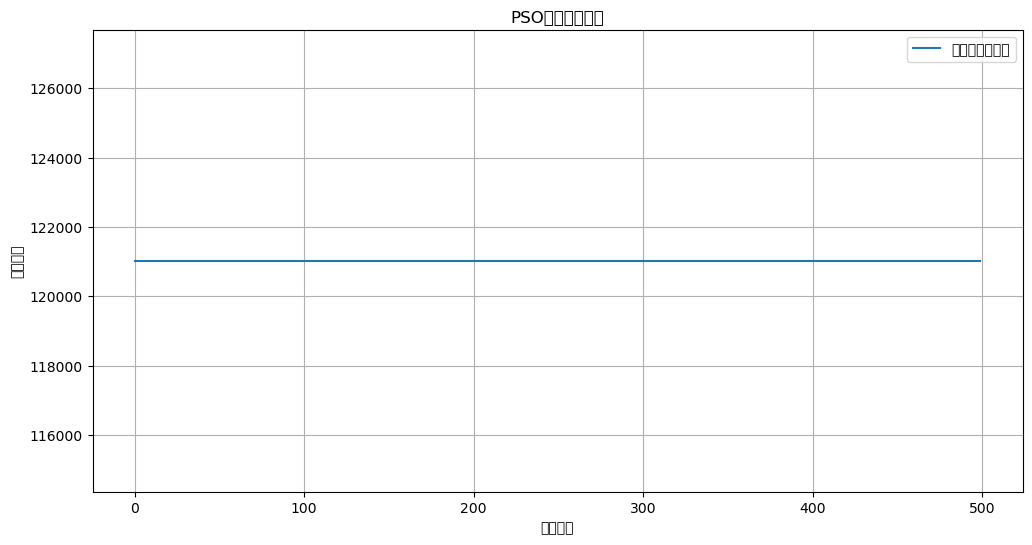

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['sans-serif']
# 使用系统已安装的中文字体，比如微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

plt.figure(figsize=(12, 6))
plt.plot(final_fitness, label='每代最佳适应度')
#plt.plot(global_best_fitness, label='全局最佳适应度')
plt.xlabel('迭代次数')
plt.ylabel('适应度值')
plt.title('PSO算法优化过程')
plt.legend()
plt.grid(True)
plt.show()